In [1]:
import pandas as pd
from tqdm.notebook import tqdm, trange
import torch
from torch.utils.data import DataLoader
import numpy as np
import torchvision
import random
from collections import defaultdict
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 160
EPOCHS = 31
BATCH_SIZE = 64
LEARNING_RATE = 0.0005

SEED = 69

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
device = torch.device(device)

train_type_dir = '../data/train/type'
train_nrj_dir = '../data/train/nrj'
test_dir = '../data/test/'

cuda


In [3]:
train_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE), 
                                       transforms.RandomHorizontalFlip(p=0.5),
                                       transforms.RandomVerticalFlip(p=0.5),
                                       transforms.RandomRotation(45),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                            [0.229, 0.224, 0.225])
                                       ])

testval_transforms = transforms.Compose([transforms.CenterCrop(RESCALE_SIZE),
                                       transforms.ToTensor(),
                                       transforms.Normalize(
                                           [0.485, 0.456, 0.406],
                                           [0.229, 0.224, 0.225])
                                       ])

In [4]:
def load_split_train_valid(datadir, batch_size, train_transforms, valid_transforms, valid_size):
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    val_data = datasets.ImageFolder(datadir, transform=testval_transforms)
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    trainloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
    valloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)   

    return trainloader, valloader

In [5]:
test_dataset = torchvision.datasets.ImageFolder(test_dir, testval_transforms)
test_loader = torch.utils.data.DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
len(test_loader), len(test_dataset)

(259, 16560)

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

In [7]:
def train_model(model, loss, optimizer, scheduler, num_epochs, train_dataloader, val_dataloader):
    hystory_loss_train = []
    hystory_loss_val = []

    hystory_acc_train = []
    hystory_acc_val = []  
    for epoch in range(num_epochs):
        print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                dataloader = train_dataloader                
                model.train()  # Set model to training mode
            else:
                dataloader = val_dataloader
                model.eval()   # Set model to evaluate mode

            running_loss = 0.
            running_acc = 0.

            # Iterate over data.
            for inputs, labels in tqdm(dataloader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                # forward and backward
                with torch.set_grad_enabled(phase == 'train'):
                    preds = model(inputs)
                    loss_value = loss(preds, labels)
                    preds_class = preds.argmax(dim=1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss_value.backward()
                        optimizer.step()

                # statistics
                running_loss += loss_value.item()
                running_acc += (preds_class == labels.data).float().mean()

            epoch_loss = running_loss / len(dataloader)
            epoch_acc = running_acc / len(dataloader)

            if phase == 'train':
                hystory_loss_train.append(epoch_loss)
                hystory_acc_train.append(epoch_acc)
                scheduler.step()
            else:
                hystory_loss_val.append(epoch_loss)
                hystory_acc_val.append(epoch_acc)


            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

    return hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val

In [8]:
class CNNc2(nn.Module): 
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop1 = nn.Dropout2d(p=0.25)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop2 = nn.Dropout2d(p=0.25)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop3 = nn.Dropout2d(p=0.25)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8192, 2048),
            nn.BatchNorm1d(2048),
            nn.ReLU(),
        )
        self.fc2 = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.out = nn.Linear(1024, 2)
    
    def forward(self, x):
        x = self.drop1(self.conv1(x))
        x = self.drop2(self.conv2(x))
        x = self.drop3(self.conv3(x))
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.out(x)
        
        return F.log_softmax(x, dim=1)

Epoch 0/30:



train Loss: 0.7341 Acc: 0.4934



val Loss: 0.7094 Acc: 0.5015
Epoch 1/30:



train Loss: 0.5727 Acc: 0.6341



val Loss: 0.2367 Acc: 0.8929
Epoch 2/30:



train Loss: 0.1082 Acc: 0.9546



val Loss: 0.0221 Acc: 0.9922
Epoch 3/30:



train Loss: 0.0345 Acc: 0.9879



val Loss: 0.0079 Acc: 0.9978
Epoch 4/30:



train Loss: 0.0286 Acc: 0.9904



val Loss: 0.0139 Acc: 0.9955
Epoch 5/30:



train Loss: 0.0194 Acc: 0.9929



val Loss: 0.0070 Acc: 0.9978
Epoch 6/30:



train Loss: 0.0133 Acc: 0.9956



val Loss: 0.0115 Acc: 0.9952
Epoch 7/30:



train Loss: 0.0145 Acc: 0.9949



val Loss: 0.0044 Acc: 0.9985
Epoch 8/30:



train Loss: 0.0153 Acc: 0.9954



val Loss: 0.0037 Acc: 0.9985
Epoch 9/30:



train Loss: 0.0151 Acc: 0.9951



val Loss: 0.0057 Acc: 0.9981
Epoch 10/30:



train Loss: 0.0129 Acc: 0.9960



val Loss: 0.0034 Acc: 0.9989
Epoch 11/30:



train Loss: 0.0123 Acc: 0.9960



val Loss: 0.0032 Acc: 0.9989
Epoch 12/30:



train Loss: 0.0109 Acc: 0.9963



val Loss: 0.0032 Acc: 0.9989
Epoch 13/30:



train Loss: 0.0088 Acc: 0.9968



val Loss: 0.0025 Acc: 0.9993
Epoch 14/30:



train Loss: 0.0125 Acc: 0.9961



val Loss: 0.0023 Acc: 0.9989
Epoch 15/30:



train Loss: 0.0130 Acc: 0.9959



val Loss: 0.0032 Acc: 0.9989
Epoch 16/30:



train Loss: 0.0103 Acc: 0.9974



val Loss: 0.0026 Acc: 0.9993
Epoch 17/30:



train Loss: 0.0078 Acc: 0.9976



val Loss: 0.0029 Acc: 0.9989
Epoch 18/30:



train Loss: 0.0100 Acc: 0.9967



val Loss: 0.0026 Acc: 0.9989
Epoch 19/30:



train Loss: 0.0076 Acc: 0.9974



val Loss: 0.0019 Acc: 0.9993
Epoch 20/30:



train Loss: 0.0092 Acc: 0.9968



val Loss: 0.0022 Acc: 0.9993
Epoch 21/30:



train Loss: 0.0085 Acc: 0.9972



val Loss: 0.0035 Acc: 0.9989
Epoch 22/30:



train Loss: 0.0097 Acc: 0.9968



val Loss: 0.0039 Acc: 0.9985
Epoch 23/30:



train Loss: 0.0075 Acc: 0.9972



val Loss: 0.0027 Acc: 0.9993
Epoch 24/30:



train Loss: 0.0079 Acc: 0.9974



val Loss: 0.0031 Acc: 0.9989
Epoch 25/30:



train Loss: 0.0072 Acc: 0.9982



val Loss: 0.0036 Acc: 0.9985
Epoch 26/30:



train Loss: 0.0081 Acc: 0.9971



val Loss: 0.0023 Acc: 0.9993
Epoch 27/30:



train Loss: 0.0073 Acc: 0.9976



val Loss: 0.0017 Acc: 0.9996
Epoch 28/30:



train Loss: 0.0066 Acc: 0.9977



val Loss: 0.0018 Acc: 0.9996
Epoch 29/30:



train Loss: 0.0069 Acc: 0.9974



val Loss: 0.0015 Acc: 0.9996
Epoch 30/30:



train Loss: 0.0070 Acc: 0.9974



val Loss: 0.0024 Acc: 0.9993



Epoch 0/30:



train Loss: 0.5911 Acc: 0.6490



val Loss: 0.2482 Acc: 0.8646
Epoch 1/30:



train Loss: 0.0922 Acc: 0.9663



val Loss: 0.0190 Acc: 0.9933
Epoch 2/30:



train Loss: 0.0332 Acc: 0.9901



val Loss: 0.0080 Acc: 0.9963
Epoch 3/30:



train Loss: 0.0262 Acc: 0.9913



val Loss: 0.0081 Acc: 0.9981
Epoch 4/30:



train Loss: 0.0241 Acc: 0.9915



val Loss: 0.0044 Acc: 0.9993
Epoch 5/30:



train Loss: 0.0164 Acc: 0.9948



val Loss: 0.0043 Acc: 0.9981
Epoch 6/30:



train Loss: 0.0117 Acc: 0.9961



val Loss: 0.0041 Acc: 0.9985
Epoch 7/30:



train Loss: 0.0107 Acc: 0.9965



val Loss: 0.0055 Acc: 0.9981
Epoch 8/30:



train Loss: 0.0139 Acc: 0.9954



val Loss: 0.0045 Acc: 0.9981
Epoch 9/30:



train Loss: 0.0118 Acc: 0.9962



val Loss: 0.0065 Acc: 0.9981
Epoch 10/30:



train Loss: 0.0161 Acc: 0.9949



val Loss: 0.0036 Acc: 0.9981
Epoch 11/30:



train Loss: 0.0149 Acc: 0.9945



val Loss: 0.0035 Acc: 0.9989
Epoch 12/30:



train Loss: 0.0122 Acc: 0.9958



val Loss: 0.0032 Acc: 0.9989
Epoch 13/30:



train Loss: 0.0101 Acc: 0.9970



val Loss: 0.0023 Acc: 0.9993
Epoch 14/30:



train Loss: 0.0072 Acc: 0.9977



val Loss: 0.0027 Acc: 0.9985
Epoch 15/30:



train Loss: 0.0074 Acc: 0.9978



val Loss: 0.0019 Acc: 0.9996
Epoch 16/30:



train Loss: 0.0094 Acc: 0.9976



val Loss: 0.0028 Acc: 0.9989
Epoch 17/30:



train Loss: 0.0080 Acc: 0.9974



val Loss: 0.0021 Acc: 0.9993
Epoch 18/30:



train Loss: 0.0078 Acc: 0.9973



val Loss: 0.0022 Acc: 0.9989
Epoch 19/30:



train Loss: 0.0075 Acc: 0.9976



val Loss: 0.0022 Acc: 0.9989
Epoch 20/30:



train Loss: 0.0069 Acc: 0.9971



val Loss: 0.0020 Acc: 0.9989
Epoch 21/30:



train Loss: 0.0106 Acc: 0.9967



val Loss: 0.0038 Acc: 0.9985
Epoch 22/30:



train Loss: 0.0084 Acc: 0.9972



val Loss: 0.0019 Acc: 0.9996
Epoch 23/30:



train Loss: 0.0071 Acc: 0.9973



val Loss: 0.0027 Acc: 0.9989
Epoch 24/30:



train Loss: 0.0083 Acc: 0.9975



val Loss: 0.0022 Acc: 0.9996
Epoch 25/30:



train Loss: 0.0096 Acc: 0.9968



val Loss: 0.0020 Acc: 0.9985
Epoch 26/30:



train Loss: 0.0061 Acc: 0.9977



val Loss: 0.0019 Acc: 0.9989
Epoch 27/30:



train Loss: 0.0073 Acc: 0.9978



val Loss: 0.0020 Acc: 0.9989
Epoch 28/30:



train Loss: 0.0079 Acc: 0.9973



val Loss: 0.0020 Acc: 0.9989
Epoch 29/30:



train Loss: 0.0064 Acc: 0.9979



val Loss: 0.0019 Acc: 0.9996
Epoch 30/30:



train Loss: 0.0061 Acc: 0.9976



val Loss: 0.0018 Acc: 0.9993



Epoch 0/30:



train Loss: 0.4052 Acc: 0.7957



val Loss: 0.0523 Acc: 0.9918
Epoch 1/30:



train Loss: 0.0499 Acc: 0.9838



val Loss: 0.0108 Acc: 0.9963
Epoch 2/30:



train Loss: 0.0352 Acc: 0.9886



val Loss: 0.0108 Acc: 0.9974
Epoch 3/30:



train Loss: 0.0187 Acc: 0.9940



val Loss: 0.0100 Acc: 0.9963
Epoch 4/30:



train Loss: 0.0243 Acc: 0.9909



val Loss: 0.0047 Acc: 0.9993
Epoch 5/30:



train Loss: 0.0199 Acc: 0.9938



val Loss: 0.0091 Acc: 0.9985
Epoch 6/30:



train Loss: 0.0149 Acc: 0.9954



val Loss: 0.0018 Acc: 0.9996
Epoch 7/30:



train Loss: 0.0141 Acc: 0.9952



val Loss: 0.0043 Acc: 0.9985
Epoch 8/30:



train Loss: 0.0086 Acc: 0.9976



val Loss: 0.0023 Acc: 0.9993
Epoch 9/30:



train Loss: 0.0154 Acc: 0.9948



val Loss: 0.0040 Acc: 0.9993
Epoch 10/30:



train Loss: 0.0134 Acc: 0.9953



val Loss: 0.0058 Acc: 0.9985
Epoch 11/30:



train Loss: 0.0138 Acc: 0.9955



val Loss: 0.0023 Acc: 0.9996
Epoch 12/30:



train Loss: 0.0089 Acc: 0.9964



val Loss: 0.0027 Acc: 0.9993
Epoch 13/30:



train Loss: 0.0079 Acc: 0.9972



val Loss: 0.0020 Acc: 0.9989
Epoch 14/30:



train Loss: 0.0082 Acc: 0.9968



val Loss: 0.0018 Acc: 0.9993
Epoch 15/30:



train Loss: 0.0106 Acc: 0.9964



val Loss: 0.0023 Acc: 0.9989
Epoch 16/30:



train Loss: 0.0073 Acc: 0.9972



val Loss: 0.0012 Acc: 0.9996
Epoch 17/30:



train Loss: 0.0092 Acc: 0.9966



val Loss: 0.0026 Acc: 0.9993
Epoch 18/30:



train Loss: 0.0071 Acc: 0.9975



val Loss: 0.0053 Acc: 0.9985
Epoch 19/30:



train Loss: 0.0076 Acc: 0.9977



val Loss: 0.0034 Acc: 0.9989
Epoch 20/30:



train Loss: 0.0064 Acc: 0.9975



val Loss: 0.0031 Acc: 0.9993
Epoch 21/30:



train Loss: 0.0084 Acc: 0.9971



val Loss: 0.0024 Acc: 0.9993
Epoch 22/30:



train Loss: 0.0061 Acc: 0.9978



val Loss: 0.0029 Acc: 0.9989
Epoch 23/30:



train Loss: 0.0073 Acc: 0.9978



val Loss: 0.0017 Acc: 0.9996
Epoch 24/30:



train Loss: 0.0056 Acc: 0.9978



val Loss: 0.0016 Acc: 0.9996
Epoch 25/30:



train Loss: 0.0068 Acc: 0.9981



val Loss: 0.0027 Acc: 0.9989
Epoch 26/30:



train Loss: 0.0071 Acc: 0.9976



val Loss: 0.0018 Acc: 0.9993
Epoch 27/30:



train Loss: 0.0081 Acc: 0.9975



val Loss: 0.0030 Acc: 0.9989
Epoch 28/30:



train Loss: 0.0080 Acc: 0.9977



val Loss: 0.0017 Acc: 0.9996
Epoch 29/30:



train Loss: 0.0068 Acc: 0.9975



val Loss: 0.0013 Acc: 0.9996
Epoch 30/30:



train Loss: 0.0082 Acc: 0.9973



val Loss: 0.0014 Acc: 0.9996



Epoch 0/30:



train Loss: 0.7045 Acc: 0.5545



val Loss: 0.4628 Acc: 0.7705
Epoch 1/30:



train Loss: 0.2013 Acc: 0.9091



val Loss: 0.0226 Acc: 0.9918
Epoch 2/30:



train Loss: 0.0427 Acc: 0.9850



val Loss: 0.0077 Acc: 0.9985
Epoch 3/30:



train Loss: 0.0323 Acc: 0.9884



val Loss: 0.0059 Acc: 0.9978
Epoch 4/30:



train Loss: 0.0186 Acc: 0.9944



val Loss: 0.0094 Acc: 0.9967
Epoch 5/30:



train Loss: 0.0240 Acc: 0.9922



val Loss: 0.0131 Acc: 0.9948
Epoch 6/30:



train Loss: 0.0195 Acc: 0.9944



val Loss: 0.0043 Acc: 0.9989
Epoch 7/30:



train Loss: 0.0196 Acc: 0.9924



val Loss: 0.0038 Acc: 0.9989
Epoch 8/30:



train Loss: 0.0121 Acc: 0.9958



val Loss: 0.0036 Acc: 0.9993
Epoch 9/30:



train Loss: 0.0121 Acc: 0.9955



val Loss: 0.0046 Acc: 0.9989
Epoch 10/30:



train Loss: 0.0132 Acc: 0.9961



val Loss: 0.0029 Acc: 0.9985
Epoch 11/30:



train Loss: 0.0137 Acc: 0.9951



val Loss: 0.0068 Acc: 0.9981
Epoch 12/30:



train Loss: 0.0122 Acc: 0.9959



val Loss: 0.0026 Acc: 0.9989
Epoch 13/30:



train Loss: 0.0106 Acc: 0.9968



val Loss: 0.0031 Acc: 0.9981
Epoch 14/30:



train Loss: 0.0097 Acc: 0.9966



val Loss: 0.0022 Acc: 0.9993
Epoch 15/30:



train Loss: 0.0086 Acc: 0.9970



val Loss: 0.0023 Acc: 0.9993
Epoch 16/30:



train Loss: 0.0078 Acc: 0.9974



val Loss: 0.0019 Acc: 0.9996
Epoch 17/30:



train Loss: 0.0086 Acc: 0.9973



val Loss: 0.0020 Acc: 0.9993
Epoch 18/30:



train Loss: 0.0070 Acc: 0.9979



val Loss: 0.0020 Acc: 0.9989
Epoch 19/30:



train Loss: 0.0098 Acc: 0.9972



val Loss: 0.0021 Acc: 0.9993
Epoch 20/30:



train Loss: 0.0082 Acc: 0.9969



val Loss: 0.0015 Acc: 0.9996
Epoch 21/30:



train Loss: 0.0058 Acc: 0.9980



val Loss: 0.0024 Acc: 0.9993
Epoch 22/30:



train Loss: 0.0089 Acc: 0.9973



val Loss: 0.0016 Acc: 0.9996
Epoch 23/30:



train Loss: 0.0070 Acc: 0.9980



val Loss: 0.0023 Acc: 0.9993
Epoch 24/30:



train Loss: 0.0067 Acc: 0.9980



val Loss: 0.0018 Acc: 0.9996
Epoch 25/30:



train Loss: 0.0073 Acc: 0.9978



val Loss: 0.0016 Acc: 0.9996
Epoch 26/30:



train Loss: 0.0065 Acc: 0.9976



val Loss: 0.0016 Acc: 0.9993
Epoch 27/30:



train Loss: 0.0069 Acc: 0.9978



val Loss: 0.0028 Acc: 0.9993
Epoch 28/30:



train Loss: 0.0058 Acc: 0.9983



val Loss: 0.0018 Acc: 0.9996
Epoch 29/30:



train Loss: 0.0070 Acc: 0.9980



val Loss: 0.0019 Acc: 0.9996
Epoch 30/30:



train Loss: 0.0051 Acc: 0.9984



val Loss: 0.0017 Acc: 0.9993



Epoch 0/30:



train Loss: 0.4889 Acc: 0.7459



val Loss: 0.1339 Acc: 0.9725
Epoch 1/30:



train Loss: 0.0622 Acc: 0.9787



val Loss: 0.0184 Acc: 0.9940
Epoch 2/30:



train Loss: 0.0316 Acc: 0.9879



val Loss: 0.0093 Acc: 0.9974
Epoch 3/30:



train Loss: 0.0296 Acc: 0.9902



val Loss: 0.0081 Acc: 0.9970
Epoch 4/30:



train Loss: 0.0223 Acc: 0.9917



val Loss: 0.0110 Acc: 0.9967
Epoch 5/30:



train Loss: 0.0206 Acc: 0.9919



val Loss: 0.0058 Acc: 0.9981
Epoch 6/30:



train Loss: 0.0167 Acc: 0.9939



val Loss: 0.0054 Acc: 0.9981
Epoch 7/30:



train Loss: 0.0147 Acc: 0.9947



val Loss: 0.0052 Acc: 0.9978
Epoch 8/30:



train Loss: 0.0107 Acc: 0.9961



val Loss: 0.0046 Acc: 0.9985
Epoch 9/30:



train Loss: 0.0140 Acc: 0.9955



val Loss: 0.0034 Acc: 0.9989
Epoch 10/30:



train Loss: 0.0119 Acc: 0.9958



val Loss: 0.0043 Acc: 0.9989
Epoch 11/30:



train Loss: 0.0140 Acc: 0.9951



val Loss: 0.0057 Acc: 0.9989
Epoch 12/30:



train Loss: 0.0103 Acc: 0.9960



val Loss: 0.0032 Acc: 0.9989
Epoch 13/30:



train Loss: 0.0072 Acc: 0.9978



val Loss: 0.0024 Acc: 0.9989
Epoch 14/30:



train Loss: 0.0104 Acc: 0.9963



val Loss: 0.0027 Acc: 0.9989
Epoch 15/30:



train Loss: 0.0085 Acc: 0.9970



val Loss: 0.0047 Acc: 0.9985
Epoch 16/30:



train Loss: 0.0078 Acc: 0.9976



val Loss: 0.0027 Acc: 0.9985
Epoch 17/30:



train Loss: 0.0081 Acc: 0.9973



val Loss: 0.0024 Acc: 0.9989
Epoch 18/30:



train Loss: 0.0071 Acc: 0.9976



val Loss: 0.0024 Acc: 0.9993
Epoch 19/30:



train Loss: 0.0071 Acc: 0.9980



val Loss: 0.0020 Acc: 0.9993
Epoch 20/30:



train Loss: 0.0068 Acc: 0.9977



val Loss: 0.0032 Acc: 0.9989
Epoch 21/30:



train Loss: 0.0062 Acc: 0.9979



val Loss: 0.0026 Acc: 0.9989
Epoch 22/30:



train Loss: 0.0075 Acc: 0.9976



val Loss: 0.0019 Acc: 0.9993
Epoch 23/30:



train Loss: 0.0068 Acc: 0.9976



val Loss: 0.0023 Acc: 0.9989
Epoch 24/30:



train Loss: 0.0076 Acc: 0.9976



val Loss: 0.0019 Acc: 0.9996
Epoch 25/30:



train Loss: 0.0070 Acc: 0.9975



val Loss: 0.0024 Acc: 0.9989
Epoch 26/30:



train Loss: 0.0066 Acc: 0.9976



val Loss: 0.0026 Acc: 0.9989
Epoch 27/30:



train Loss: 0.0064 Acc: 0.9976



val Loss: 0.0023 Acc: 0.9989
Epoch 28/30:



train Loss: 0.0071 Acc: 0.9973



val Loss: 0.0021 Acc: 0.9993
Epoch 29/30:



train Loss: 0.0068 Acc: 0.9980



val Loss: 0.0027 Acc: 0.9989
Epoch 30/30:



train Loss: 0.0052 Acc: 0.9982



val Loss: 0.0022 Acc: 0.9989



Epoch 0/30:



train Loss: 0.6307 Acc: 0.6138



val Loss: 0.2974 Acc: 0.8419
Epoch 1/30:



train Loss: 0.1131 Acc: 0.9552



val Loss: 0.0155 Acc: 0.9974
Epoch 2/30:



train Loss: 0.0359 Acc: 0.9881



val Loss: 0.0217 Acc: 0.9926
Epoch 3/30:



train Loss: 0.0250 Acc: 0.9916



val Loss: 0.0152 Acc: 0.9952
Epoch 4/30:



train Loss: 0.0249 Acc: 0.9926



val Loss: 0.0119 Acc: 0.9967
Epoch 5/30:



train Loss: 0.0222 Acc: 0.9931



val Loss: 0.0097 Acc: 0.9963
Epoch 6/30:



train Loss: 0.0131 Acc: 0.9959



val Loss: 0.0071 Acc: 0.9978
Epoch 7/30:



train Loss: 0.0124 Acc: 0.9957



val Loss: 0.0102 Acc: 0.9974
Epoch 8/30:



train Loss: 0.0126 Acc: 0.9956



val Loss: 0.0075 Acc: 0.9970
Epoch 9/30:



train Loss: 0.0149 Acc: 0.9947



val Loss: 0.0097 Acc: 0.9970
Epoch 10/30:



train Loss: 0.0088 Acc: 0.9965



val Loss: 0.0106 Acc: 0.9963
Epoch 11/30:



train Loss: 0.0126 Acc: 0.9959



val Loss: 0.0066 Acc: 0.9978
Epoch 12/30:



train Loss: 0.0114 Acc: 0.9964



val Loss: 0.0066 Acc: 0.9974
Epoch 13/30:



train Loss: 0.0083 Acc: 0.9974



val Loss: 0.0054 Acc: 0.9981
Epoch 14/30:



train Loss: 0.0099 Acc: 0.9959



val Loss: 0.0093 Acc: 0.9967
Epoch 15/30:



train Loss: 0.0095 Acc: 0.9968



val Loss: 0.0053 Acc: 0.9981
Epoch 16/30:



train Loss: 0.0082 Acc: 0.9968



val Loss: 0.0051 Acc: 0.9985
Epoch 17/30:



train Loss: 0.0109 Acc: 0.9960



val Loss: 0.0067 Acc: 0.9978
Epoch 18/30:



train Loss: 0.0101 Acc: 0.9967



val Loss: 0.0052 Acc: 0.9985
Epoch 19/30:



train Loss: 0.0084 Acc: 0.9976



val Loss: 0.0051 Acc: 0.9985
Epoch 20/30:



train Loss: 0.0067 Acc: 0.9981



val Loss: 0.0069 Acc: 0.9978
Epoch 21/30:



train Loss: 0.0083 Acc: 0.9972



val Loss: 0.0064 Acc: 0.9978
Epoch 22/30:



train Loss: 0.0070 Acc: 0.9976



val Loss: 0.0054 Acc: 0.9981
Epoch 23/30:



train Loss: 0.0065 Acc: 0.9981



val Loss: 0.0064 Acc: 0.9978
Epoch 24/30:



train Loss: 0.0071 Acc: 0.9976



val Loss: 0.0074 Acc: 0.9974
Epoch 25/30:



train Loss: 0.0073 Acc: 0.9973



val Loss: 0.0064 Acc: 0.9981
Epoch 26/30:



train Loss: 0.0075 Acc: 0.9973



val Loss: 0.0063 Acc: 0.9981
Epoch 27/30:



train Loss: 0.0046 Acc: 0.9991



val Loss: 0.0073 Acc: 0.9974
Epoch 28/30:



train Loss: 0.0061 Acc: 0.9974



val Loss: 0.0072 Acc: 0.9978
Epoch 29/30:



train Loss: 0.0052 Acc: 0.9984



val Loss: 0.0065 Acc: 0.9981
Epoch 30/30:



train Loss: 0.0060 Acc: 0.9983



val Loss: 0.0075 Acc: 0.9974



Epoch 0/30:



train Loss: 0.5384 Acc: 0.7026



val Loss: 0.2187 Acc: 0.9077
Epoch 1/30:



train Loss: 0.0649 Acc: 0.9759



val Loss: 0.0162 Acc: 0.9955
Epoch 2/30:



train Loss: 0.0332 Acc: 0.9889



val Loss: 0.0065 Acc: 0.9981
Epoch 3/30:



train Loss: 0.0252 Acc: 0.9915



val Loss: 0.0094 Acc: 0.9974
Epoch 4/30:



train Loss: 0.0239 Acc: 0.9914



val Loss: 0.0168 Acc: 0.9955
Epoch 5/30:



train Loss: 0.0250 Acc: 0.9913



val Loss: 0.0123 Acc: 0.9967
Epoch 6/30:



train Loss: 0.0145 Acc: 0.9958



val Loss: 0.0083 Acc: 0.9981
Epoch 7/30:



train Loss: 0.0145 Acc: 0.9947



val Loss: 0.0105 Acc: 0.9981
Epoch 8/30:



train Loss: 0.0143 Acc: 0.9947



val Loss: 0.0042 Acc: 0.9989
Epoch 9/30:



train Loss: 0.0117 Acc: 0.9959



val Loss: 0.0059 Acc: 0.9989
Epoch 10/30:



train Loss: 0.0116 Acc: 0.9962



val Loss: 0.0061 Acc: 0.9981
Epoch 11/30:



train Loss: 0.0134 Acc: 0.9962



val Loss: 0.0035 Acc: 0.9993
Epoch 12/30:



train Loss: 0.0113 Acc: 0.9964



val Loss: 0.0020 Acc: 0.9993
Epoch 13/30:



train Loss: 0.0093 Acc: 0.9970



val Loss: 0.0026 Acc: 0.9989
Epoch 14/30:



train Loss: 0.0090 Acc: 0.9969



val Loss: 0.0029 Acc: 0.9981
Epoch 15/30:



train Loss: 0.0084 Acc: 0.9973



val Loss: 0.0034 Acc: 0.9989
Epoch 16/30:



train Loss: 0.0094 Acc: 0.9975



val Loss: 0.0036 Acc: 0.9989
Epoch 17/30:



train Loss: 0.0113 Acc: 0.9967



val Loss: 0.0061 Acc: 0.9985
Epoch 18/30:



train Loss: 0.0101 Acc: 0.9963



val Loss: 0.0042 Acc: 0.9989
Epoch 19/30:



train Loss: 0.0079 Acc: 0.9971



val Loss: 0.0016 Acc: 0.9996
Epoch 20/30:



train Loss: 0.0087 Acc: 0.9974



val Loss: 0.0026 Acc: 0.9989
Epoch 21/30:



train Loss: 0.0073 Acc: 0.9978



val Loss: 0.0019 Acc: 0.9993
Epoch 22/30:



train Loss: 0.0108 Acc: 0.9967



val Loss: 0.0051 Acc: 0.9985
Epoch 23/30:



train Loss: 0.0075 Acc: 0.9973



val Loss: 0.0019 Acc: 0.9996
Epoch 24/30:



train Loss: 0.0085 Acc: 0.9973



val Loss: 0.0019 Acc: 0.9996
Epoch 25/30:



train Loss: 0.0087 Acc: 0.9969



val Loss: 0.0022 Acc: 0.9996
Epoch 26/30:



train Loss: 0.0068 Acc: 0.9979



val Loss: 0.0018 Acc: 0.9996
Epoch 27/30:



train Loss: 0.0073 Acc: 0.9974



val Loss: 0.0016 Acc: 0.9996
Epoch 28/30:



train Loss: 0.0071 Acc: 0.9976



val Loss: 0.0036 Acc: 0.9993
Epoch 29/30:



train Loss: 0.0057 Acc: 0.9980



val Loss: 0.0026 Acc: 0.9996
Epoch 30/30:



train Loss: 0.0085 Acc: 0.9972



val Loss: 0.0022 Acc: 0.9996




Wall time: 3h 50min 8s


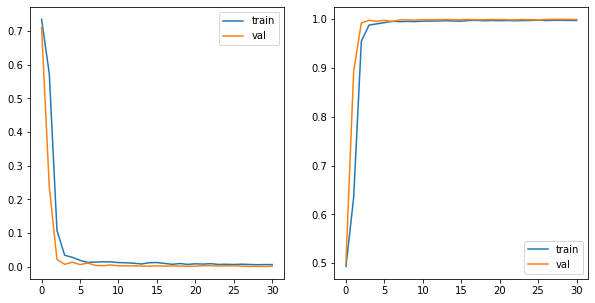

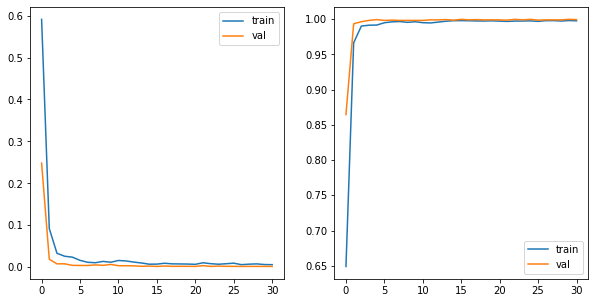

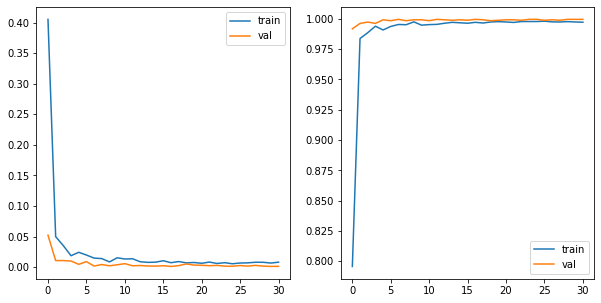

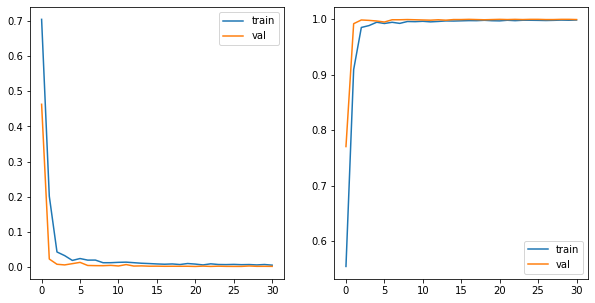

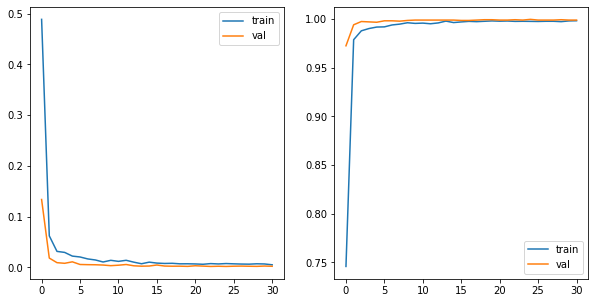

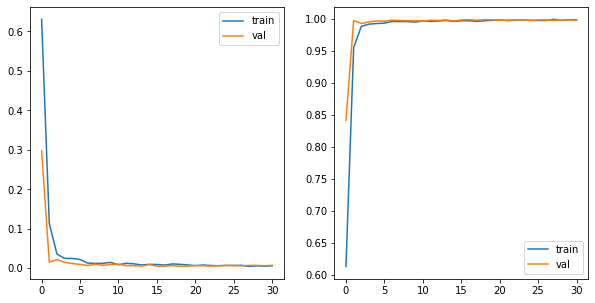

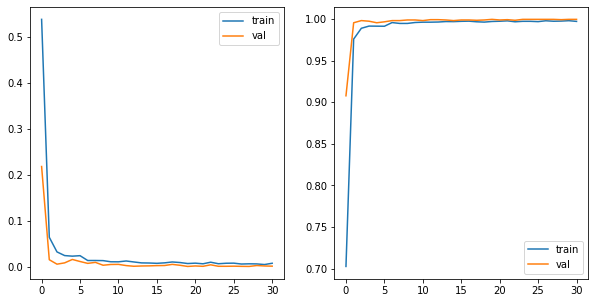

In [9]:
%%time
dict_pred = defaultdict(list)
file_names = []
for line in test_dataset.imgs:
    file_names.append(str(line).split('/')[-1].split('.')[0])

dict_pred['id'] = file_names

for i in trange(7):
    set_seed(SEED+i)
    
    train_type_loader, val_type_loader = load_split_train_valid(datadir=train_type_dir,                                                              
                                                              batch_size=BATCH_SIZE,
                                                              train_transforms=train_transforms,
                                                              valid_transforms=testval_transforms,
                                                              valid_size = .2)
    
    net = CNNc2()
    net = net.to(device)
    
    loss = nn.NLLLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=LEARNING_RATE)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.5)
    hystory_loss_train, hystory_loss_val, hystory_acc_train, hystory_acc_val =\
    train_model(net, loss, optimizer, scheduler, EPOCHS, train_type_loader, val_type_loader);
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(hystory_loss_train, label='train')
    ax1.plot(hystory_loss_val, label='val')
    ax1.legend()

    ax2.plot(hystory_acc_train, label='train')
    ax2.plot(hystory_acc_val, label='val')
    ax2.legend()
    
    net.eval()
    dict_pred[f'CNNc2-{i}'] = []
    with torch.no_grad():
        for _, (img, name) in enumerate(tqdm(test_loader)):
            img = img.to(device)
            outputs = net(img)
            _, predicted = torch.max(outputs.data, dim=1)
            predicted = list(map(int, predicted.cpu()))
            dict_pred[f'CNNc2-{i}'].extend(predicted)

    del net
    torch.cuda.empty_cache()

In [10]:
data_frame = pd.DataFrame.from_dict(dict_pred)
data_frame.head()

,id,CNNc2-0,CNNc2-1,CNNc2-2,CNNc2-3,CNNc2-4,CNNc2-5,CNNc2-6
0,private_test\\00013a94f1fae3e5a33f8b44c2842c85...,0,0,0,0,0,0,0
1,private_test\\0005564c011259402dcb6e3beb6e64d2...,0,0,0,0,0,0,0
2,private_test\\0007520c8d8efade8feaafbf74fc7d20...,1,1,1,1,1,1,1
3,private_test\\000804a189f630cd980ff1543c0ef99d...,1,1,1,1,1,1,1
4,private_test\\000eb12def5371089743dcfe401a8e39...,1,1,1,1,1,1,1


In [11]:
data_frame['CNNc2-0'] = data_frame['CNNc2-0'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['CNNc2-1'] = data_frame['CNNc2-1'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['CNNc2-2'] = data_frame['CNNc2-2'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['CNNc2-3'] = data_frame['CNNc2-3'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['CNNc2-4'] = data_frame['CNNc2-4'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['CNNc2-5'] = data_frame['CNNc2-5'].replace({
    0: '1',  #ER
    1: '0'}) #NR
data_frame['CNNc2-6'] = data_frame['CNNc2-6'].replace({
    0: '1',  #ER
    1: '0'}) #NR

In [12]:
data_frame['id'] = data_frame['id'].apply(lambda x: x.split('\\\\')[1])
data_frame.head()

,id,CNNc2-0,CNNc2-1,CNNc2-2,CNNc2-3,CNNc2-4,CNNc2-5,CNNc2-6
0,00013a94f1fae3e5a33f8b44c2842c85f0483e96,1,1,1,1,1,1,1
1,0005564c011259402dcb6e3beb6e64d285124fa0,1,1,1,1,1,1,1
2,0007520c8d8efade8feaafbf74fc7d206cdf229d,0,0,0,0,0,0,0
3,000804a189f630cd980ff1543c0ef99d48cd6b34,0,0,0,0,0,0,0
4,000eb12def5371089743dcfe401a8e399f5883fc,0,0,0,0,0,0,0


In [13]:
data_frame.to_csv('CNNc2.csv', index=False, header=True)